# Train a small transformer model on preprocessed segments

This notebook loads `segments_preproc_24.csv` produced by the preprocessing notebook, builds segment-level sequences, and trains a small transformer-based classifier.

In [119]:
# Imports and configuration
import os
import math
import numpy as np
import pandas as pd

import torch
from torch import nn
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report

BASE_DATA_DIR = os.path.abspath("../data")
EXPORT_DIR = os.path.join(BASE_DATA_DIR, "export")
PREPROC_CSV = os.path.join(EXPORT_DIR, "segments_preproc_24.csv")

print("Using preprocessed file:", PREPROC_CSV)
assert os.path.exists(PREPROC_CSV), f"Preprocessed CSV not found: {PREPROC_CSV}"

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device:", device)

Using preprocessed file: /work/data/export/segments_preproc_24.csv
Device: cuda


In [120]:
# Set random seeds for reproducibility
import random
import numpy as np
import torch

SEED = 1
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
if torch.cuda.is_available():
    torch.cuda.manual_seed(SEED)
    torch.cuda.manual_seed_all(SEED)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False
print(f"Random seed locked to {SEED}")

Random seed locked to 1


In [121]:
# Model evaluation configuration
# Change this single variable to switch the primary metric for model selection
# Options: 'auc_ovo', 'auc_ovr', 'f1', 'accuracy', 'pr_auc'
PRIMARY_METRIC = 'pr_auc'

# Metric display names and whether higher is better
METRIC_CONFIG = {
    'auc_ovo': {
        'name': 'AUC-ROC (OvO)',
        'short': 'ovo',
        'higher_is_better': True,
        'description': 'One-vs-One: evaluates all pairwise class comparisons'
    },
    'auc_ovr': {
        'name': 'AUC-ROC (OvR)',
        'short': 'ovr',
        'higher_is_better': True,
        'description': 'One-vs-Rest: evaluates each class vs all others'
    },
    'f1': {
        'name': 'F1 Score (macro)',
        'short': 'f1',
        'higher_is_better': True,
        'description': 'Harmonic mean of precision and recall'
    },
    'accuracy': {
        'name': 'Accuracy',
        'short': 'acc',
        'higher_is_better': True,
        'description': 'Proportion of correct predictions'
    },
    'pr_auc': {
        'name': 'PR-AUC (macro)',
        'short': 'pr',
        'higher_is_better': True,
        'description': 'Precision-Recall curve area (macro): better for imbalanced classes'
    }
}

print(f"Primary metric: {METRIC_CONFIG[PRIMARY_METRIC]['name']}")
print(f"Description: {METRIC_CONFIG[PRIMARY_METRIC]['description']}")

Primary metric: PR-AUC (macro)
Description: Precision-Recall curve area (macro): better for imbalanced classes


In [122]:
# Load preprocessed dataset and build segment-level sequences
df = pd.read_csv(PREPROC_CSV)
print("Raw preprocessed shape:", df.shape)

# Ensure correct ordering within each segment
df = df.sort_values(["segment_id", "seq_pos"], kind="mergesort").reset_index(drop=True)

feature_cols = [c for c in df.columns if c not in ["segment_id", "label", "csv_file", "seq_pos"]]
print("Feature columns (", len(feature_cols), "):", feature_cols)

# Group into (segment, sequence of length 24, label)
segments = []
labels = []

for seg_id, g in df.groupby("segment_id", sort=True):
    g = g.sort_values("seq_pos", kind="mergesort")
    feat = g[feature_cols].to_numpy(dtype=np.float32)
    # Expect 24 steps; if shorter/longer, adjust with simple strategies
    if feat.shape[0] < 24:
        # pad by repeating last step
        pad = np.repeat(feat[-1:, :], 24 - feat.shape[0], axis=0)
        feat = np.concatenate([feat, pad], axis=0)
    elif feat.shape[0] > 24:
        # truncate extra steps
        feat = feat[:24, :]

    assert feat.shape[0] == 24, feat.shape
    segments.append(feat)
    labels.append(g["label"].iloc[0])

X = np.stack(segments, axis=0)  # (N, 24, F)
y = np.array(labels)

print("Num segments:", X.shape[0], "Seq len:", X.shape[1], "Num features:", X.shape[2])
print("Label distribution:")
print(pd.Series(y).value_counts())

Raw preprocessed shape: (3456, 12)
Feature columns ( 8 ): ['open_norm', 'high_norm', 'low_norm', 'close_norm', 'vol_close', 'vol_high_low', 'compression_ratio', 'trend']
Num segments: 144 Seq len: 24 Num features: 8
Label distribution:
Bullish Normal     40
Bearish Normal     27
Bearish Pennant    26
Bullish Pennant    22
Bullish Wedge      15
Bearish Wedge      14
Name: count, dtype: int64


In [123]:
# Encode labels as integers
label_values = np.sort(pd.unique(y))
label_to_idx = {lbl: i for i, lbl in enumerate(label_values)}
idx_to_label = {i: lbl for lbl, i in label_to_idx.items()}

y_idx = np.vectorize(label_to_idx.get)(y)
num_classes = len(label_values)
print("Classes:", label_values, "-> num_classes =", num_classes)

Classes: ['Bearish Normal' 'Bearish Pennant' 'Bearish Wedge' 'Bullish Normal'
 'Bullish Pennant' 'Bullish Wedge'] -> num_classes = 6


In [124]:
# Train/validation split at segment level
X_train, X_val, y_train, y_val = train_test_split(
    X, y_idx, test_size=0.2, random_state=SEED, stratify=y_idx,
 )

print("Train segments:", X_train.shape[0])
print("Val segments:", X_val.shape[0])

class SegmentDataset(Dataset):
    def __init__(self, X, y):
        self.X = torch.from_numpy(X)  # (N, T, F)
        self.y = torch.from_numpy(y).long()
    def __len__(self):
        return self.X.shape[0]
    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

train_ds = SegmentDataset(X_train, y_train)
val_ds = SegmentDataset(X_val, y_val)

batch_size = 12
train_loader = DataLoader(train_ds, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_ds, batch_size=batch_size, shuffle=False)

len(train_loader), len(val_loader)

Train segments: 115
Val segments: 29


(10, 3)

In [125]:
# Extended CNN-based classifier for pattern recognition
class SimpleCNN(nn.Module):
    def __init__(self, input_dim: int, num_classes: int, hidden_channels: int = 64):
        super().__init__()
        # Input: (B, T, F) -> rearrange to (B, F, T) for Conv1d
        self.conv = nn.Sequential(
            # Block 1
            nn.Conv1d(in_channels=input_dim, out_channels=hidden_channels, kernel_size=3, padding=1),
            nn.BatchNorm1d(hidden_channels),
            nn.ReLU(),
            nn.Dropout(0.1),
            # Block 2
            nn.Conv1d(in_channels=hidden_channels, out_channels=hidden_channels, kernel_size=3, padding=1),
            nn.BatchNorm1d(hidden_channels),
            nn.ReLU(),
            nn.Dropout(0.1),
            # Block 3
            nn.Conv1d(in_channels=hidden_channels, out_channels=hidden_channels * 2, kernel_size=3, padding=1),
            nn.BatchNorm1d(hidden_channels * 2),
            nn.ReLU(),
            nn.Dropout(0.1),
            # Block 4
            nn.Conv1d(in_channels=hidden_channels * 2, out_channels=hidden_channels * 2, kernel_size=3, padding=1),
            nn.BatchNorm1d(hidden_channels * 2),
            nn.ReLU(),
        )
        self.pool = nn.AdaptiveAvgPool1d(1)  # global average over time
        self.fc = nn.Sequential(
            nn.Linear(hidden_channels * 2, hidden_channels),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(hidden_channels, hidden_channels // 2),
            nn.ReLU(),
            nn.Linear(hidden_channels // 2, num_classes),
        )
        # Apply Xavier initialization for better stability
        self._init_weights()

    def _init_weights(self):
        for m in self.modules():
            if isinstance(m, nn.Conv1d):
                nn.init.xavier_uniform_(m.weight, gain=nn.init.calculate_gain('relu'))
                if m.bias is not None:
                    nn.init.zeros_(m.bias)
            elif isinstance(m, nn.BatchNorm1d):
                nn.init.ones_(m.weight)
                nn.init.zeros_(m.bias)
            elif isinstance(m, nn.Linear):
                nn.init.xavier_uniform_(m.weight)
                if m.bias is not None:
                    nn.init.zeros_(m.bias)

    def forward(self, x):  # x: (B, T, F)
        x = x.transpose(1, 2)  # (B, F, T)
        h = self.conv(x)
        h = self.pool(h).squeeze(-1)  # (B, C)
        logits = self.fc(h)
        return logits

model = SimpleCNN(input_dim=X.shape[2], num_classes=num_classes).to(device)

# Calculate class weights for imbalanced dataset
class_counts = np.bincount(y_idx)
class_weights = 1.0 / class_counts
class_weights = class_weights / class_weights.sum() * len(class_weights)
class_weights_tensor = torch.FloatTensor(class_weights).to(device)

print(f"Class distribution: {class_counts}")
print(f"Class weights: {class_weights}")

criterion = nn.CrossEntropyLoss(weight=class_weights_tensor)
optimizer = torch.optim.AdamW(model.parameters(), lr=1e-3, weight_decay=1e-4)

# Learning rate scheduler for better convergence
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=20)

print(model)
print(f"\nTotal parameters: {sum(p.numel() for p in model.parameters()):,}")
print(f"\n{'='*60}")
print(f"PRIMARY METRIC: {METRIC_CONFIG[PRIMARY_METRIC]['name']}")
print(f"Description: {METRIC_CONFIG[PRIMARY_METRIC]['description']}")
print(f"{'='*60}")

Class distribution: [27 26 14 40 22 15]
Class weights: [0.7823394  0.81242937 1.50879741 0.52807909 0.96014381 1.40821092]
SimpleCNN(
  (conv): Sequential(
    (0): Conv1d(8, 64, kernel_size=(3,), stride=(1,), padding=(1,))
    (1): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Dropout(p=0.1, inplace=False)
    (4): Conv1d(64, 64, kernel_size=(3,), stride=(1,), padding=(1,))
    (5): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): ReLU()
    (7): Dropout(p=0.1, inplace=False)
    (8): Conv1d(64, 128, kernel_size=(3,), stride=(1,), padding=(1,))
    (9): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): ReLU()
    (11): Dropout(p=0.1, inplace=False)
    (12): Conv1d(128, 128, kernel_size=(3,), stride=(1,), padding=(1,))
    (13): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (14): ReLU()
  )
  (pool): Adaptive

In [ ]:
# Training loop using the extended CNN
from sklearn.metrics import f1_score, roc_auc_score, average_precision_score
from sklearn.preprocessing import label_binarize

def run_epoch(loader, model, criterion, optimizer=None):
    is_train = optimizer is not None
    total_loss = 0.0
    all_preds = []
    all_probs = []
    all_targets = []

    if is_train:
        model.train()
    else:
        model.eval()

    for xb, yb in loader:
        xb = xb.to(device)
        yb = yb.to(device)

        with torch.set_grad_enabled(is_train):
            logits = model(xb)
            loss = criterion(logits, yb)
            if is_train:
                optimizer.zero_grad()
                loss.backward()
                optimizer.step()

        total_loss += loss.item() * xb.size(0)
        probs = torch.softmax(logits, dim=1).detach().cpu().numpy()
        preds = logits.argmax(dim=1).detach().cpu().numpy()
        all_probs.append(probs)
        all_preds.append(preds)
        all_targets.append(yb.detach().cpu().numpy())

    all_probs = np.concatenate(all_probs)
    all_preds = np.concatenate(all_preds)
    all_targets = np.concatenate(all_targets)
    
    # Calculate all metrics
    metrics = {}
    metrics['loss'] = total_loss / len(loader.dataset)
    metrics['accuracy'] = accuracy_score(all_targets, all_preds)
    metrics['f1'] = f1_score(all_targets, all_preds, average='macro')
    
    # Calculate AUC-ROC metrics (both OvO and OvR)
    try:
        metrics['auc_ovo'] = roc_auc_score(all_targets, all_probs, multi_class='ovo', average='macro')
        metrics['auc_ovr'] = roc_auc_score(all_targets, all_probs, multi_class='ovr', average='macro')
    except ValueError:
        # In case some classes are missing
        metrics['auc_ovo'] = 0.0
        metrics['auc_ovr'] = 0.0
    
    # Calculate PR-AUC (Precision-Recall AUC) - macro average
    try:
        # Binarize labels for multi-class PR-AUC
        y_bin = label_binarize(all_targets, classes=range(all_probs.shape[1]))
        pr_auc_per_class = []
        for i in range(all_probs.shape[1]):
            pr_auc_per_class.append(average_precision_score(y_bin[:, i], all_probs[:, i]))
        metrics['pr_auc'] = np.mean(pr_auc_per_class)
    except ValueError:
        metrics['pr_auc'] = 0.0
    
    return metrics, all_probs

# Create checkpoint directory
checkpoint_dir = os.path.join(EXPORT_DIR, "checkpoints")
os.makedirs(checkpoint_dir, exist_ok=True)
print(f"Checkpoints will be saved to: {checkpoint_dir}")

num_epochs = 60  # More epochs for deeper model
best_val_metric = 0.0 if METRIC_CONFIG[PRIMARY_METRIC]['higher_is_better'] else float('inf')
best_checkpoint_path = None

# Initialize history tracking
history = {
    'train_loss': [],
    'val_loss': [],
    'train_metric': [],
    'val_metric': [],
    'epochs': []
}

for epoch in range(1, num_epochs + 1):
    train_metrics, _ = run_epoch(train_loader, model, criterion, optimizer)
    val_metrics, _ = run_epoch(val_loader, model, criterion, optimizer=None)
    scheduler.step()
    
    # Store history
    history['epochs'].append(epoch)
    history['train_loss'].append(train_metrics['loss'])
    history['val_loss'].append(val_metrics['loss'])
    history['train_metric'].append(train_metrics[PRIMARY_METRIC])
    history['val_metric'].append(val_metrics[PRIMARY_METRIC])
    
    # Check if this is the best model based on primary metric
    current_val_metric = val_metrics[PRIMARY_METRIC]
    is_best = False
    
    if METRIC_CONFIG[PRIMARY_METRIC]['higher_is_better']:
        if current_val_metric > best_val_metric:
            best_val_metric = current_val_metric
            is_best = True
    else:
        if current_val_metric < best_val_metric:
            best_val_metric = current_val_metric
            is_best = True
    
    if is_best:
        best_marker = " *"
        
        # Save the best model checkpoint
        metric_short = METRIC_CONFIG[PRIMARY_METRIC]['short']
        best_checkpoint_path = os.path.join(
            checkpoint_dir, 
            f"best_model_epoch{epoch:02d}_{metric_short}{current_val_metric:.4f}.pt"
        )
        checkpoint = {
            'epoch': epoch,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'scheduler_state_dict': scheduler.state_dict(),
            'train_metrics': train_metrics,
            'val_metrics': val_metrics,
            'best_val_metric': best_val_metric,
            'primary_metric': PRIMARY_METRIC,
            'label_to_idx': label_to_idx,
            'idx_to_label': idx_to_label,
            'num_classes': num_classes,
            'input_dim': X.shape[2],
            'history': history,  # Save training history
        }
        torch.save(checkpoint, best_checkpoint_path)
        print(f"Saved best checkpoint: {os.path.basename(best_checkpoint_path)}")
    else:
        best_marker = ""
    
    lr = optimizer.param_groups[0]['lr']
    print(f"Epoch {epoch:02d} | lr={lr:.6f} | "
          f"train_loss={train_metrics['loss']:.4f} acc={train_metrics['accuracy']:.4f} "
          f"f1={train_metrics['f1']:.4f} pr={train_metrics['pr_auc']:.4f} ovo={train_metrics['auc_ovo']:.4f} ovr={train_metrics['auc_ovr']:.4f} | "
          f"val_loss={val_metrics['loss']:.4f} acc={val_metrics['accuracy']:.4f} "
          f"f1={val_metrics['f1']:.4f} pr={val_metrics['pr_auc']:.4f} ovo={val_metrics['auc_ovo']:.4f} ovr={val_metrics['auc_ovr']:.4f}{best_marker}")

print(f"\nBest validation {METRIC_CONFIG[PRIMARY_METRIC]['name']}: {best_val_metric:.4f}")
print(f"Best checkpoint saved at: {best_checkpoint_path}")

Checkpoints will be saved to: /work/data/export/checkpoints


Saved best checkpoint: best_model_epoch01_pr0.2825.pt
Epoch 01 | lr=0.000994 | train_loss=1.8002 acc=0.2348 f1=0.1694 pr=0.2356 ovo=0.5436 ovr=0.5411 | val_loss=1.7843 acc=0.1379 f1=0.0430 pr=0.2825 ovo=0.5891 ovr=0.5989 *
Saved best checkpoint: best_model_epoch02_pr0.3134.pt
Epoch 02 | lr=0.000976 | train_loss=1.7103 acc=0.2696 f1=0.2288 pr=0.2808 ovo=0.6424 ovr=0.6511 | val_loss=1.7480 acc=0.3103 f1=0.2389 pr=0.3134 ovo=0.6038 ovr=0.6070 *
Saved best checkpoint: best_model_epoch03_pr0.3710.pt
Epoch 03 | lr=0.000946 | train_loss=1.5938 acc=0.3478 f1=0.2823 pr=0.3414 ovo=0.6940 ovr=0.7042 | val_loss=1.6962 acc=0.3103 f1=0.1889 pr=0.3710 ovo=0.6382 ovr=0.6460 *
Saved best checkpoint: best_model_epoch02_pr0.3134.pt
Epoch 02 | lr=0.000976 | train_loss=1.7103 acc=0.2696 f1=0.2288 pr=0.2808 ovo=0.6424 ovr=0.6511 | val_loss=1.7480 acc=0.3103 f1=0.2389 pr=0.3134 ovo=0.6038 ovr=0.6070 *
Saved best checkpoint: best_model_epoch03_pr0.3710.pt
Epoch 03 | lr=0.000946 | train_loss=1.5938 acc=0.3478 

In [ ]:
# Plot training history
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

# Plot loss curves
ax1.plot(history['epochs'], history['train_loss'], 'b-', label='Training Loss', linewidth=2)
ax1.plot(history['epochs'], history['val_loss'], 'r-', label='Validation Loss', linewidth=2)
ax1.set_xlabel('Epoch', fontsize=12)
ax1.set_ylabel('Loss', fontsize=12)
ax1.set_title('Training and Validation Loss', fontsize=14, fontweight='bold')
ax1.legend(fontsize=10)
ax1.grid(True, alpha=0.3)

# Plot metric curves
metric_display_name = METRIC_CONFIG[PRIMARY_METRIC]['name']
ax2.plot(history['epochs'], history['train_metric'], 'b-', label=f'Training {metric_display_name}', linewidth=2)
ax2.plot(history['epochs'], history['val_metric'], 'r-', label=f'Validation {metric_display_name}', linewidth=2)
ax2.set_xlabel('Epoch', fontsize=12)
ax2.set_ylabel(metric_display_name, fontsize=12)
ax2.set_title(f'Training and Validation {metric_display_name}', fontsize=14, fontweight='bold')
ax2.legend(fontsize=10)
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

In [127]:
# Load the best checkpoint
if best_checkpoint_path and os.path.exists(best_checkpoint_path):
    print(f"Loading best checkpoint from: {best_checkpoint_path}")
    checkpoint = torch.load(best_checkpoint_path, map_location=device, weights_only=False)
    
    # Restore model state
    model.load_state_dict(checkpoint['model_state_dict'])
    
    train_m = checkpoint['train_metrics']
    val_m = checkpoint['val_metrics']
    
    print(f"\nBest model loaded from epoch {checkpoint['epoch']}")
    print(f"Selected based on: {METRIC_CONFIG[checkpoint['primary_metric']]['name']}")
    print(f"\nTraining Metrics:")
    print(f"  Accuracy: {train_m['accuracy']:.4f}")
    print(f"  F1 (macro): {train_m['f1']:.4f}")
    print(f"  PR-AUC (macro): {train_m['pr_auc']:.4f}")
    print(f"  AUC-ROC (OvO): {train_m['auc_ovo']:.4f}")
    print(f"  AUC-ROC (OvR): {train_m['auc_ovr']:.4f}")
    print(f"\nValidation Metrics:")
    print(f"  Accuracy: {val_m['accuracy']:.4f}")
    print(f"  F1 (macro): {val_m['f1']:.4f}")
    print(f"  PR-AUC (macro): {val_m['pr_auc']:.4f} {'← PRIMARY' if checkpoint['primary_metric'] == 'pr_auc' else ''}")
    print(f"  AUC-ROC (OvO): {val_m['auc_ovo']:.4f} {'← PRIMARY' if checkpoint['primary_metric'] == 'auc_ovo' else ''}")
    print(f"  AUC-ROC (OvR): {val_m['auc_ovr']:.4f} {'← PRIMARY' if checkpoint['primary_metric'] == 'auc_ovr' else ''}")
    print(f"  Loss: {val_m['loss']:.4f}")
    
    model.eval()
else:
    print("No checkpoint found - using final training state")

Loading best checkpoint from: /work/data/export/checkpoints/best_model_epoch06_pr0.4560.pt

Best model loaded from epoch 6
Selected based on: PR-AUC (macro)

Training Metrics:
  Accuracy: 0.3739
  F1 (macro): 0.2845
  PR-AUC (macro): 0.3838
  AUC-ROC (OvO): 0.7986
  AUC-ROC (OvR): 0.8050

Validation Metrics:
  Accuracy: 0.4138
  F1 (macro): 0.3555
  PR-AUC (macro): 0.4560 ← PRIMARY
  AUC-ROC (OvO): 0.7784 
  AUC-ROC (OvR): 0.7753 
  Loss: 1.5355


Train accuracy: 0.4522
Train F1 (macro): 0.3748
Train PR-AUC (macro): 0.5314
Train AUC-ROC (OvO): 0.8621
Train AUC-ROC (OvR): 0.8632

Val accuracy: 0.4138
Val F1 (macro): 0.3555
Val PR-AUC (macro): 0.4560 ← PRIMARY METRIC
Val AUC-ROC (OvO): 0.7784 
Val AUC-ROC (OvR): 0.7753 

Model selected based on: PR-AUC (macro) = 0.4560


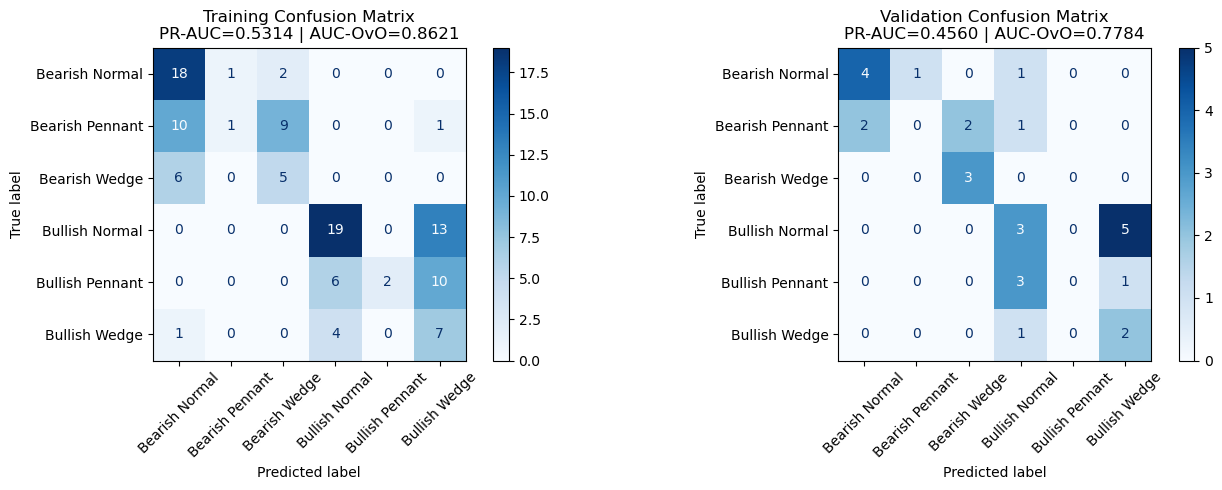


Classification report (validation):
                 precision    recall  f1-score   support

 Bearish Normal       0.67      0.67      0.67         6
Bearish Pennant       0.00      0.00      0.00         5
  Bearish Wedge       0.60      1.00      0.75         3
 Bullish Normal       0.33      0.38      0.35         8
Bullish Pennant       0.00      0.00      0.00         4
  Bullish Wedge       0.25      0.67      0.36         3

       accuracy                           0.41        29
      macro avg       0.31      0.45      0.36        29
   weighted avg       0.32      0.41      0.35        29



/opt/conda/envs/workenv/lib/python3.13/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/opt/conda/envs/workenv/lib/python3.13/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/opt/conda/envs/workenv/lib/python3.13/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0]

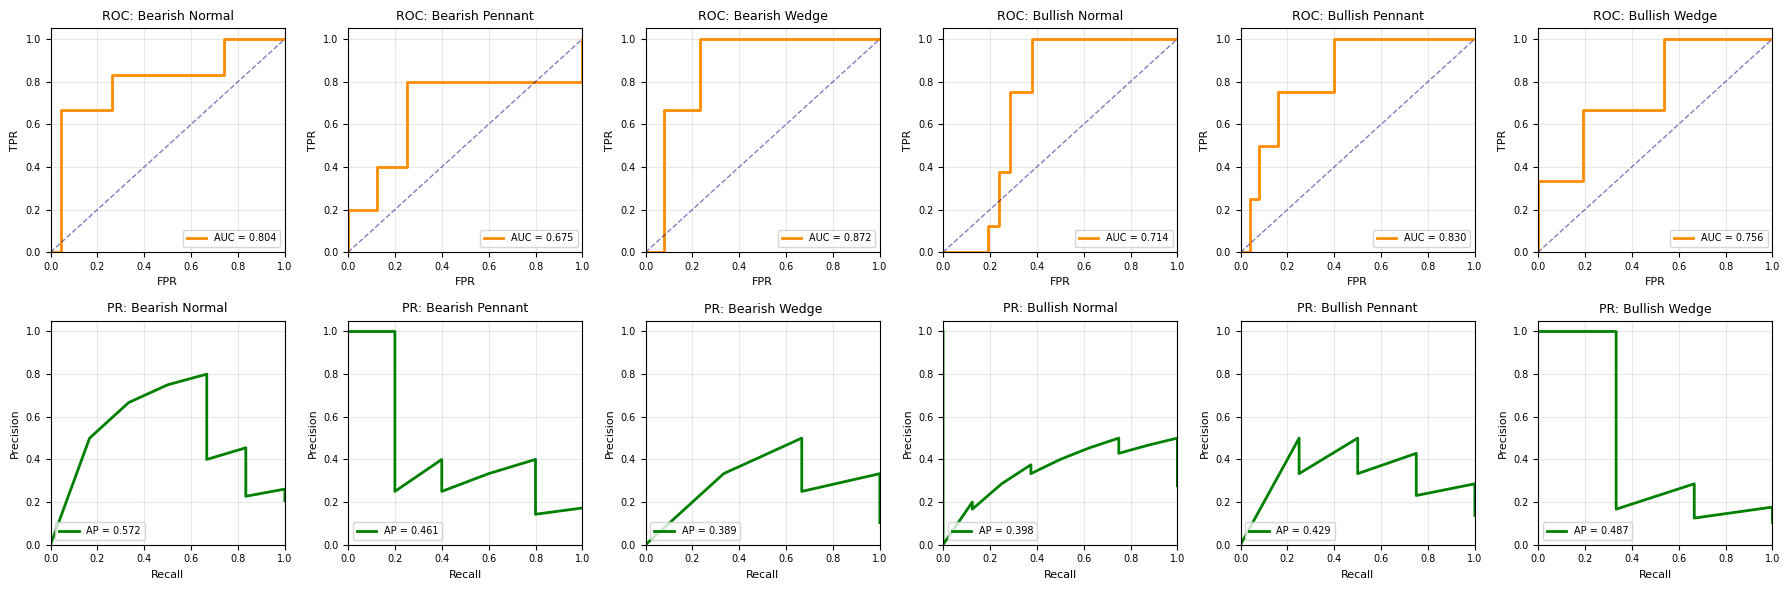

In [128]:
# Final evaluation and per-class metrics on validation set
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, f1_score, roc_auc_score, roc_curve, auc
from sklearn.metrics import precision_recall_curve, average_precision_score
from sklearn.preprocessing import label_binarize

model.eval()

def get_predictions(loader):
    all_preds = []
    all_probs = []
    all_targets = []
    for xb, yb in loader:
        xb = xb.to(device)
        with torch.no_grad():
            logits = model(xb)
            probs = torch.softmax(logits, dim=1).cpu().numpy()
            preds = logits.argmax(dim=1).cpu().numpy()
        all_probs.append(probs)
        all_preds.append(preds)
        all_targets.append(yb.numpy())
    return np.concatenate(all_preds), np.concatenate(all_targets), np.concatenate(all_probs)

# Get predictions for train and validation sets
train_preds, train_targets, train_probs = get_predictions(train_loader)
val_preds, val_targets, val_probs = get_predictions(val_loader)

# Calculate all metrics
train_acc = accuracy_score(train_targets, train_preds)
train_f1 = f1_score(train_targets, train_preds, average='macro')
train_auc_ovo = roc_auc_score(train_targets, train_probs, multi_class='ovo', average='macro')
train_auc_ovr = roc_auc_score(train_targets, train_probs, multi_class='ovr', average='macro')

val_acc = accuracy_score(val_targets, val_preds)
val_f1 = f1_score(val_targets, val_preds, average='macro')
val_auc_ovo = roc_auc_score(val_targets, val_probs, multi_class='ovo', average='macro')
val_auc_ovr = roc_auc_score(val_targets, val_probs, multi_class='ovr', average='macro')

# Calculate PR-AUC
train_targets_bin = label_binarize(train_targets, classes=range(num_classes))
val_targets_bin = label_binarize(val_targets, classes=range(num_classes))

train_pr_auc_per_class = [average_precision_score(train_targets_bin[:, i], train_probs[:, i]) for i in range(num_classes)]
val_pr_auc_per_class = [average_precision_score(val_targets_bin[:, i], val_probs[:, i]) for i in range(num_classes)]

train_pr_auc = np.mean(train_pr_auc_per_class)
val_pr_auc = np.mean(val_pr_auc_per_class)

# Create a metrics dictionary for easy lookup
val_metrics_dict = {
    'accuracy': val_acc,
    'f1': val_f1,
    'auc_ovo': val_auc_ovo,
    'auc_ovr': val_auc_ovr,
    'pr_auc': val_pr_auc
}

print(f"Train accuracy: {train_acc:.4f}")
print(f"Train F1 (macro): {train_f1:.4f}")
print(f"Train PR-AUC (macro): {train_pr_auc:.4f}")
print(f"Train AUC-ROC (OvO): {train_auc_ovo:.4f}")
print(f"Train AUC-ROC (OvR): {train_auc_ovr:.4f}")
print(f"\nVal accuracy: {val_acc:.4f}")
print(f"Val F1 (macro): {val_f1:.4f}")
print(f"Val PR-AUC (macro): {val_pr_auc:.4f} {'← PRIMARY METRIC' if PRIMARY_METRIC == 'pr_auc' else ''}")
print(f"Val AUC-ROC (OvO): {val_auc_ovo:.4f} {'← PRIMARY METRIC' if PRIMARY_METRIC == 'auc_ovo' else ''}")
print(f"Val AUC-ROC (OvR): {val_auc_ovr:.4f} {'← PRIMARY METRIC' if PRIMARY_METRIC == 'auc_ovr' else ''}")
print(f"\nModel selected based on: {METRIC_CONFIG[PRIMARY_METRIC]['name']} = {val_metrics_dict[PRIMARY_METRIC]:.4f}")

# Plot confusion matrices side by side
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Training confusion matrix
cm_train = confusion_matrix(train_targets, train_preds)
disp_train = ConfusionMatrixDisplay(confusion_matrix=cm_train, display_labels=label_values)
disp_train.plot(ax=axes[0], cmap='Blues', xticks_rotation=45)
axes[0].set_title(f"Training Confusion Matrix\nPR-AUC={train_pr_auc:.4f} | AUC-OvO={train_auc_ovo:.4f}")

# Validation confusion matrix
cm_val = confusion_matrix(val_targets, val_preds)
disp_val = ConfusionMatrixDisplay(confusion_matrix=cm_val, display_labels=label_values)
disp_val.plot(ax=axes[1], cmap='Blues', xticks_rotation=45)
axes[1].set_title(f"Validation Confusion Matrix\nPR-AUC={val_pr_auc:.4f} | AUC-OvO={val_auc_ovo:.4f}")

plt.tight_layout()
plt.show()

# Classification report for validation
print("\nClassification report (validation):")
print(classification_report(val_targets, val_preds, target_names=[str(lbl) for lbl in label_values]))

# Plot ROC curves and PR curves side by side for each class
fig, axes = plt.subplots(2, 6, figsize=(18, 6))

for i in range(num_classes):
    # ROC curve (left column)
    fpr, tpr, _ = roc_curve(val_targets_bin[:, i], val_probs[:, i])
    roc_auc_class = auc(fpr, tpr)
    
    axes[0, i].plot(fpr, tpr, color='darkorange', lw=2, label=f'AUC = {roc_auc_class:.3f}')
    axes[0, i].plot([0, 1], [0, 1], color='navy', lw=1, linestyle='--', alpha=0.5)
    axes[0, i].set_xlim([0.0, 1.0])
    axes[0, i].set_ylim([0.0, 1.05])
    axes[0, i].set_xlabel('FPR', fontsize=8)
    axes[0, i].set_ylabel('TPR', fontsize=8)
    axes[0, i].set_title(f'ROC: {label_values[i]}', fontsize=9)
    axes[0, i].legend(loc="lower right", fontsize=7)
    axes[0, i].grid(alpha=0.3)
    axes[0, i].tick_params(labelsize=7)
    
    # PR curve (right column)
    precision, recall, _ = precision_recall_curve(val_targets_bin[:, i], val_probs[:, i])
    pr_auc_class = val_pr_auc_per_class[i]
    
    axes[1, i].plot(recall, precision, color='green', lw=2, label=f'AP = {pr_auc_class:.3f}')
    axes[1, i].set_xlim([0.0, 1.0])
    axes[1, i].set_ylim([0.0, 1.05])
    axes[1, i].set_xlabel('Recall', fontsize=8)
    axes[1, i].set_ylabel('Precision', fontsize=8)
    axes[1, i].set_title(f'PR: {label_values[i]}', fontsize=9)
    axes[1, i].legend(loc="lower left", fontsize=7)
    axes[1, i].grid(alpha=0.3)
    axes[1, i].tick_params(labelsize=7)

plt.tight_layout()
plt.show()

In [129]:
# Reload the baseline_model module to pick up any changes
import importlib
import sys

# Remove cached module if it exists
if 'baseline_model' in sys.modules:
    del sys.modules['baseline_model']

# Re-import
import baseline_model
print("Baseline model reloaded with current slope_threshold:", baseline_model.BaselineModel().slope_threshold)

Baseline model reloaded with current slope_threshold: 0.0002


Using segments CSV for baseline: /work/data/export/segments_values.csv
Baseline results shape: (144, 4)
Using slope_threshold: 0.0002
Number of evaluated segments: 144
Baseline accuracy: 0.3542
Baseline F1 score (macro): 0.3129
Baseline classes: ['Bearish Normal' 'Bearish Pennant' 'Bearish Wedge' 'Bullish Normal'
 'Bullish Pennant' 'Bullish Wedge']

Classification report (baseline):
                 precision    recall  f1-score   support

 Bearish Normal       0.38      0.33      0.35        27
Bearish Pennant       0.29      0.15      0.20        26
  Bearish Wedge       0.24      0.50      0.33        14
 Bullish Normal       0.55      0.57      0.56        40
Bullish Pennant       0.38      0.14      0.20        22
  Bullish Wedge       0.19      0.33      0.24        15

       accuracy                           0.35       144
      macro avg       0.33      0.34      0.31       144
   weighted avg       0.37      0.35      0.35       144



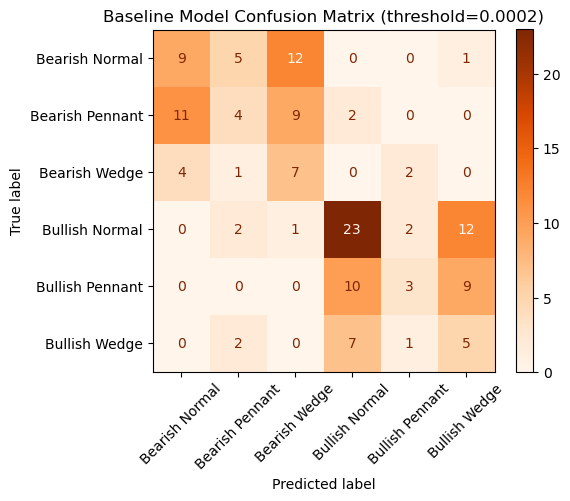

In [130]:
# Evaluate baseline model on the combined segments CSV and plot confusion matrix
import os
from baseline_model import predict_from_segments_csv, evaluate_on_segments_csv

# Path to the combined segment CSV produced by 01-data-exploration.ipynb
segments_csv_path = os.path.abspath("../data/export/segments_values.csv")
print("Using segments CSV for baseline:", segments_csv_path)

# Custom slope threshold for baseline model
BASELINE_SLOPE_THRESHOLD = 0.0002

# Run baseline model on all segments; this returns a DataFrame
baseline_results = predict_from_segments_csv(segments_csv_path, slope_threshold=BASELINE_SLOPE_THRESHOLD)
print("Baseline results shape:", baseline_results.shape)
print(f"Using slope_threshold: {BASELINE_SLOPE_THRESHOLD}")

# Keep only rows with ground-truth labels
mask = baseline_results["gold_label"].notna()
baseline_labels = baseline_results.loc[mask, "gold_label"].values
baseline_preds = baseline_results.loc[mask, "predicted_label"].values

print("Number of evaluated segments:", baseline_labels.shape[0])

# Print accuracy, F1 score, and classification report
from sklearn.metrics import accuracy_score, f1_score, classification_report, confusion_matrix, ConfusionMatrixDisplay
baseline_acc = accuracy_score(baseline_labels, baseline_preds)
baseline_f1 = f1_score(baseline_labels, baseline_preds, average='macro')
print(f"Baseline accuracy: {baseline_acc:.4f}")
print(f"Baseline F1 score (macro): {baseline_f1:.4f}")

# Use label set from the baseline outputs
import numpy as np
baseline_label_values = np.sort(pd.unique(baseline_labels))
print("Baseline classes:", baseline_label_values)

print("\nClassification report (baseline):")
print(classification_report(baseline_labels, baseline_preds,
                            labels=baseline_label_values,
                            target_names=[str(lbl) for lbl in baseline_label_values]))

# Plot confusion matrix for baseline model
import matplotlib.pyplot as plt
cm_baseline = confusion_matrix(baseline_labels, baseline_preds, labels=baseline_label_values)
disp_baseline = ConfusionMatrixDisplay(confusion_matrix=cm_baseline, display_labels=baseline_label_values)
fig, ax = plt.subplots(figsize=(6, 5))
disp_baseline.plot(ax=ax, cmap="Oranges", xticks_rotation=45)
ax.set_title(f"Baseline Model Confusion Matrix (threshold={BASELINE_SLOPE_THRESHOLD})")
plt.tight_layout()
plt.show()

Confusion matrix classes (ordered):

 ['Bearish Normal' 'Bearish Pennant' 'Bearish Wedge' 'Bullish Normal'
 'Bullish Pennant' 'Bullish Wedge']


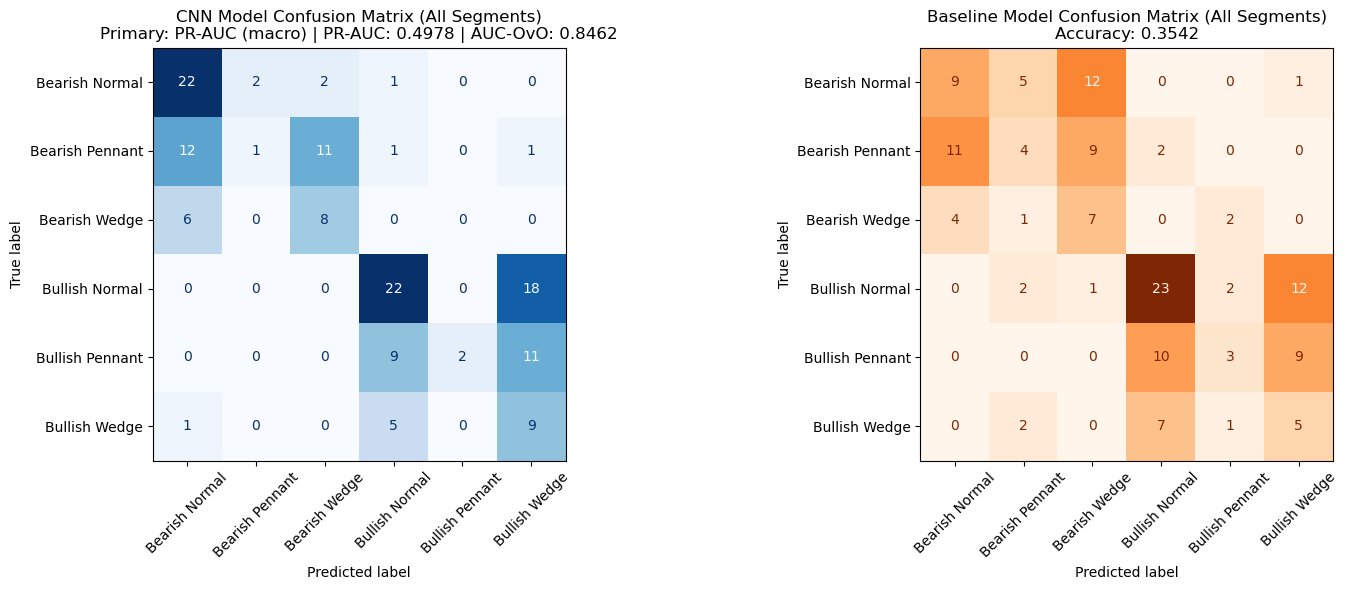


MODEL COMPARISON SUMMARY
CNN Model (selected by PR-AUC (macro)):
  Accuracy:         0.4444
  F1 Score (macro): 0.3729
  PR-AUC (macro):   0.4978  ← precision-recall curve
  AUC-ROC (OvO):    0.8462  ← pairwise discrimination (15 comparisons)
  AUC-ROC (OvR):    0.8466  ← each-vs-rest (6 comparisons)

Baseline Model (heuristic):
  Accuracy:         0.3542
  F1 Score (macro): 0.3129

PR-AUC is particularly useful for imbalanced datasets
It focuses on positive class performance and precision-recall trade-offs


In [131]:
# Compare confusion matrices of CNN model vs baseline on all segments
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, roc_auc_score, average_precision_score

# 1) CNN model predictions on all segments used for training
full_ds = SegmentDataset(X, y_idx)
full_loader = DataLoader(full_ds, batch_size=batch_size, shuffle=False)

cnn_preds_all, cnn_targets_all, cnn_probs_all = get_predictions(full_loader)

# Map integer indices back to label strings
cnn_true_labels = np.vectorize(idx_to_label.get)(cnn_targets_all)
cnn_pred_labels = np.vectorize(idx_to_label.get)(cnn_preds_all)

# Calculate all CNN metrics
cnn_acc = accuracy_score(cnn_true_labels, cnn_pred_labels)
cnn_f1 = f1_score(cnn_true_labels, cnn_pred_labels, average='macro')
cnn_auc_ovo = roc_auc_score(cnn_targets_all, cnn_probs_all, multi_class='ovo', average='macro')
cnn_auc_ovr = roc_auc_score(cnn_targets_all, cnn_probs_all, multi_class='ovr', average='macro')

# Calculate PR-AUC for CNN
cnn_targets_bin = label_binarize(cnn_targets_all, classes=range(num_classes))
cnn_pr_auc_per_class = [average_precision_score(cnn_targets_bin[:, i], cnn_probs_all[:, i]) for i in range(num_classes)]
cnn_pr_auc = np.mean(cnn_pr_auc_per_class)

# 2) Baseline predictions (already computed from segments_values.csv)
#    Using baseline_labels and baseline_preds from the previous cell

# Use the global label set from the CNN pipeline for consistent ordering
all_labels = label_values
print("Confusion matrix classes (ordered):", all_labels)

cm_cnn_all = confusion_matrix(cnn_true_labels, cnn_pred_labels, labels=all_labels)
cm_baseline_all = confusion_matrix(baseline_labels, baseline_preds, labels=all_labels)

fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# CNN confusion matrix
cnn_disp = ConfusionMatrixDisplay(confusion_matrix=cm_cnn_all, display_labels=all_labels)
cnn_disp.plot(ax=axes[0], cmap="Blues", xticks_rotation=45, colorbar=False)
axes[0].set_title(f"CNN Model Confusion Matrix (All Segments)\n"
                  f"Primary: {METRIC_CONFIG[PRIMARY_METRIC]['name']} | "
                  f"PR-AUC: {cnn_pr_auc:.4f} | AUC-OvO: {cnn_auc_ovo:.4f}")

# Baseline confusion matrix
base_disp = ConfusionMatrixDisplay(confusion_matrix=cm_baseline_all, display_labels=all_labels)
base_disp.plot(ax=axes[1], cmap="Oranges", xticks_rotation=45, colorbar=False)
axes[1].set_title(f"Baseline Model Confusion Matrix (All Segments)\nAccuracy: {baseline_acc:.4f}")

plt.tight_layout()
plt.show()

# Print comparison summary
print("\n" + "="*70)
print("MODEL COMPARISON SUMMARY")
print("="*70)
print(f"CNN Model (selected by {METRIC_CONFIG[PRIMARY_METRIC]['name']}):")
print(f"  Accuracy:         {cnn_acc:.4f}")
print(f"  F1 Score (macro): {cnn_f1:.4f}")
print(f"  PR-AUC (macro):   {cnn_pr_auc:.4f}  ← precision-recall curve")
print(f"  AUC-ROC (OvO):    {cnn_auc_ovo:.4f}  ← pairwise discrimination (15 comparisons)")
print(f"  AUC-ROC (OvR):    {cnn_auc_ovr:.4f}  ← each-vs-rest (6 comparisons)")
print(f"\nBaseline Model (heuristic):")
print(f"  Accuracy:         {baseline_acc:.4f}")
print(f"  F1 Score (macro): {baseline_f1:.4f}")
print("="*70)
print(f"\nPR-AUC is particularly useful for imbalanced datasets")
print(f"It focuses on positive class performance and precision-recall trade-offs")